# Encoding referer and user-agent

In [1]:
from skipgram import *
import pandas as pd

ROOT_DIR = os.path.dirname(os.path.abspath(""))

file = os.path.join(ROOT_DIR, "data/sitges_access.csv")
df = pd.read_csv(file)
df.head()

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,level
0,0,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:00+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
1,1,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:01+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223,-,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
2,2,www.sitgesanytime.com,40.77.167.53,-,-,2024-01-22 00:00:06+01:00,GET,/ca/noticias/84/sitges-obt%C3%A9-el-certificat...,404,2509,-,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",5
3,3,sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:06+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0
4,4,www.sitgesanytime.com,47.76.35.19,-,-,2024-01-22 00:00:07+01:00,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260,-,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0


## user-agent

In [2]:
useragent = df["user-agent"]
useragent.isna().sum()

0

In [3]:
dict(useragent.value_counts(normalize=True))["-"]

0.0010330492215932347

In [4]:
useragent[useragent != "-"].str.len().describe()

count    1.076280e+06
mean     9.060534e+01
std      3.483293e+01
min      4.000000e+00
25%      6.600000e+01
50%      6.600000e+01
75%      1.140000e+02
max      4.100000e+02
Name: user-agent, dtype: float64

In [5]:
useragent = useragent.sample(frac=1, random_state=42).reset_index(drop=True)
useragent = useragent.dropna()
useragent = useragent[useragent != "-"]

In [6]:
useragent_corpus = useragent.tolist()

In [7]:
tokenizer = train_tokenizer(useragent_corpus,
							vocab_size=1000,
							min_frequency=10,
							save_prefix="charbpe-useragent",
							save_dir=os.path.join(ROOT_DIR, "models"))

In [8]:
tokenized_useragent_corpus = tokenize_corpus(useragent_corpus, tokenizer)
trimmed_useragent_corpus = trim_corpus(tokenized_useragent_corpus, 5)

  0%|          | 0/1076280 [00:00<?, ?it/s]

100%|██████████| 1076280/1076280 [00:08<00:00, 132194.19it/s]


In [9]:
word2idx, idx2word, vocab = create_lookup_tables(trimmed_useragent_corpus)

In [10]:
subsampled_useragent_corpus = subsample(trimmed_useragent_corpus, word2idx, 1e-2)

100%|██████████| 1076280/1076280 [00:09<00:00, 113630.13it/s]


Subsampled 14850285 tokens from the corpus. 58.78% of the corpus remaining.


In [11]:
print(useragent_corpus[0])
print(" ".join([idx2word[i] for i in subsampled_useragent_corpus[0]]).replace("</w>", ""))

Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1
( iPhone CPU iPhone OS 17 _ 2 _ 1 like Mac OS X AppleWebKit 605 . 1 15 KHTML , like Gecko ) Version 17 2 Mobile / 15E148 Safari 604 . 1


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 30
batch_size = 512
context_size = 5
n_neg_samples = 5

noise_dist = generate_noise_dist(subsampled_useragent_corpus, len(vocab))
model = SkipGram(len(vocab), embedding_dim, noise_dist=noise_dist).to(device)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [13]:
train_skipgram(
	model,
	criterion,
	optimizer,
	subsampled_useragent_corpus,
	device,
	batch_size=batch_size,
	context_size=context_size,
	n_epochs=1,
	n_neg_samples=n_neg_samples,
	idx2word=idx2word
)

Epoch  1/ 1 | Batch 41351/41356 | Loss: 1.8799
_</w> | X</w>, Mac</w>, OS</w>, ES</w>, 14541</w>
2</w> | 3</w>, 1</w>, iPhone16</w>, help</w>, A53
KHTML</w> | ,</w>, MMB29P</w>, 35, AppleWebKit</w>, K</w>
7</w> | Intel</w>, Applebot</w>, Macintosh</w>, Y</w>, ahrefs</w>
AhrefsBot</w> | ahrefs</w>, robot</w>, Barkrowler</w>, imagesift</w>, ImagesiftBot</w>
SAMSUNG</w> | SM</w>, A5, A3, S9, G9
79</w> | 65</w>, 72</w>, 77</w>, 67</w>, 71</w>
2 | 3, 24, 34, 26, 394
1 | 25, 20</w>, 146</w>, 18, 28
9</w> | 11</w>, M, 181</w>, eek, j



In [15]:
save_embeddings(model, os.path.join(ROOT_DIR, "models", "embeddings-useragent.pt"))
save_idx2word(idx2word, os.path.join(ROOT_DIR, "models", "idx2word-useragent.json"))
embeddings = load_embeddings(os.path.join(ROOT_DIR, "models", "embeddings-useragent.pt"))

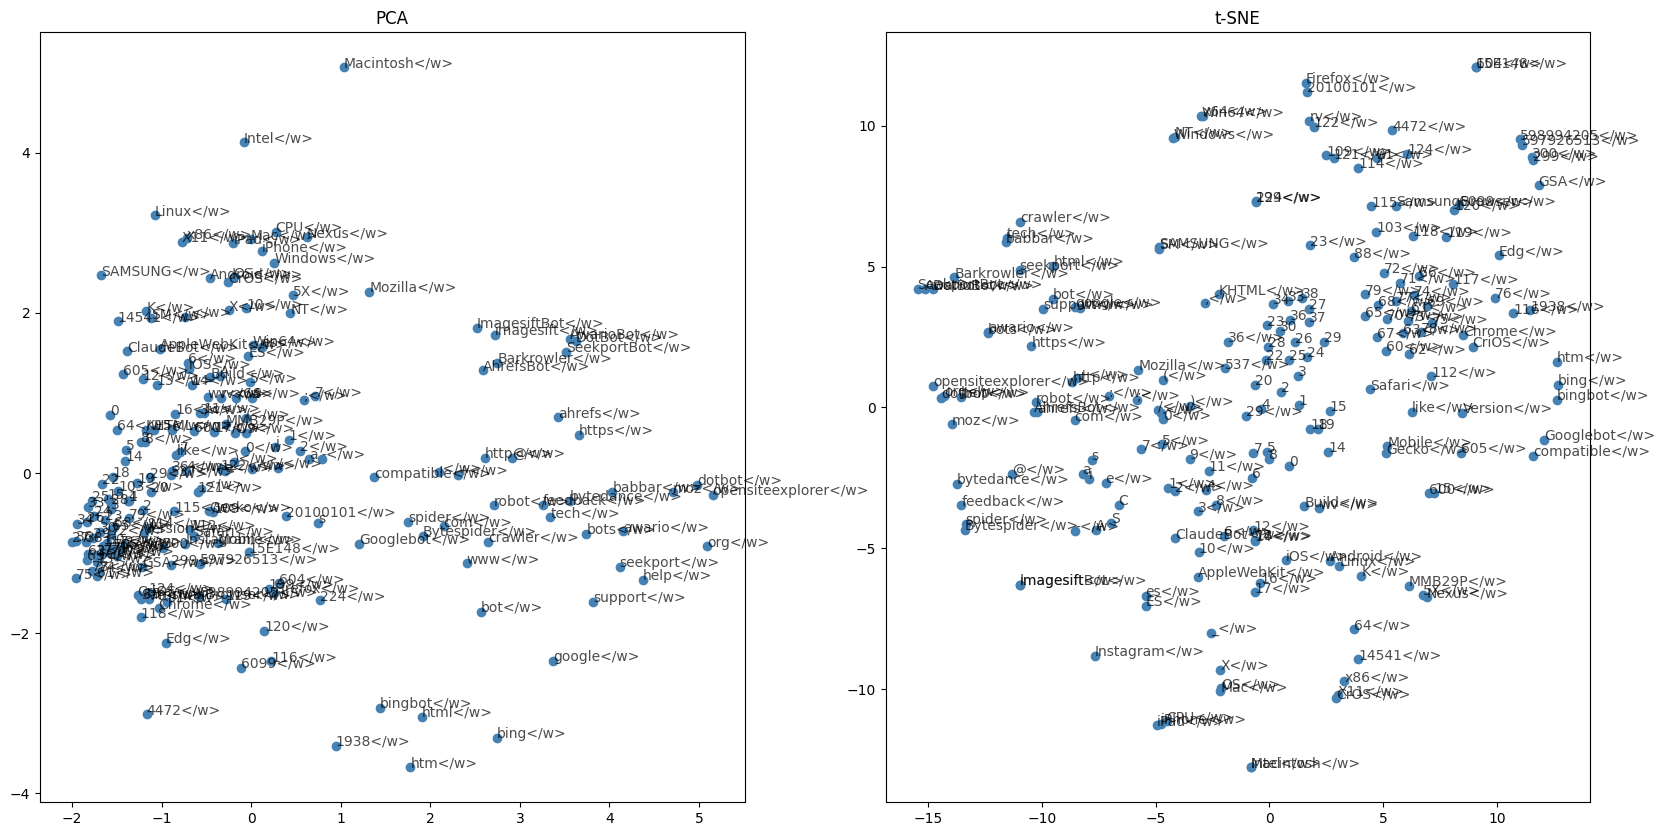

In [16]:
visualize_embeddings(
	embeddings,
	idx2word,
	method="both",
	figsize=(20, 10),
)

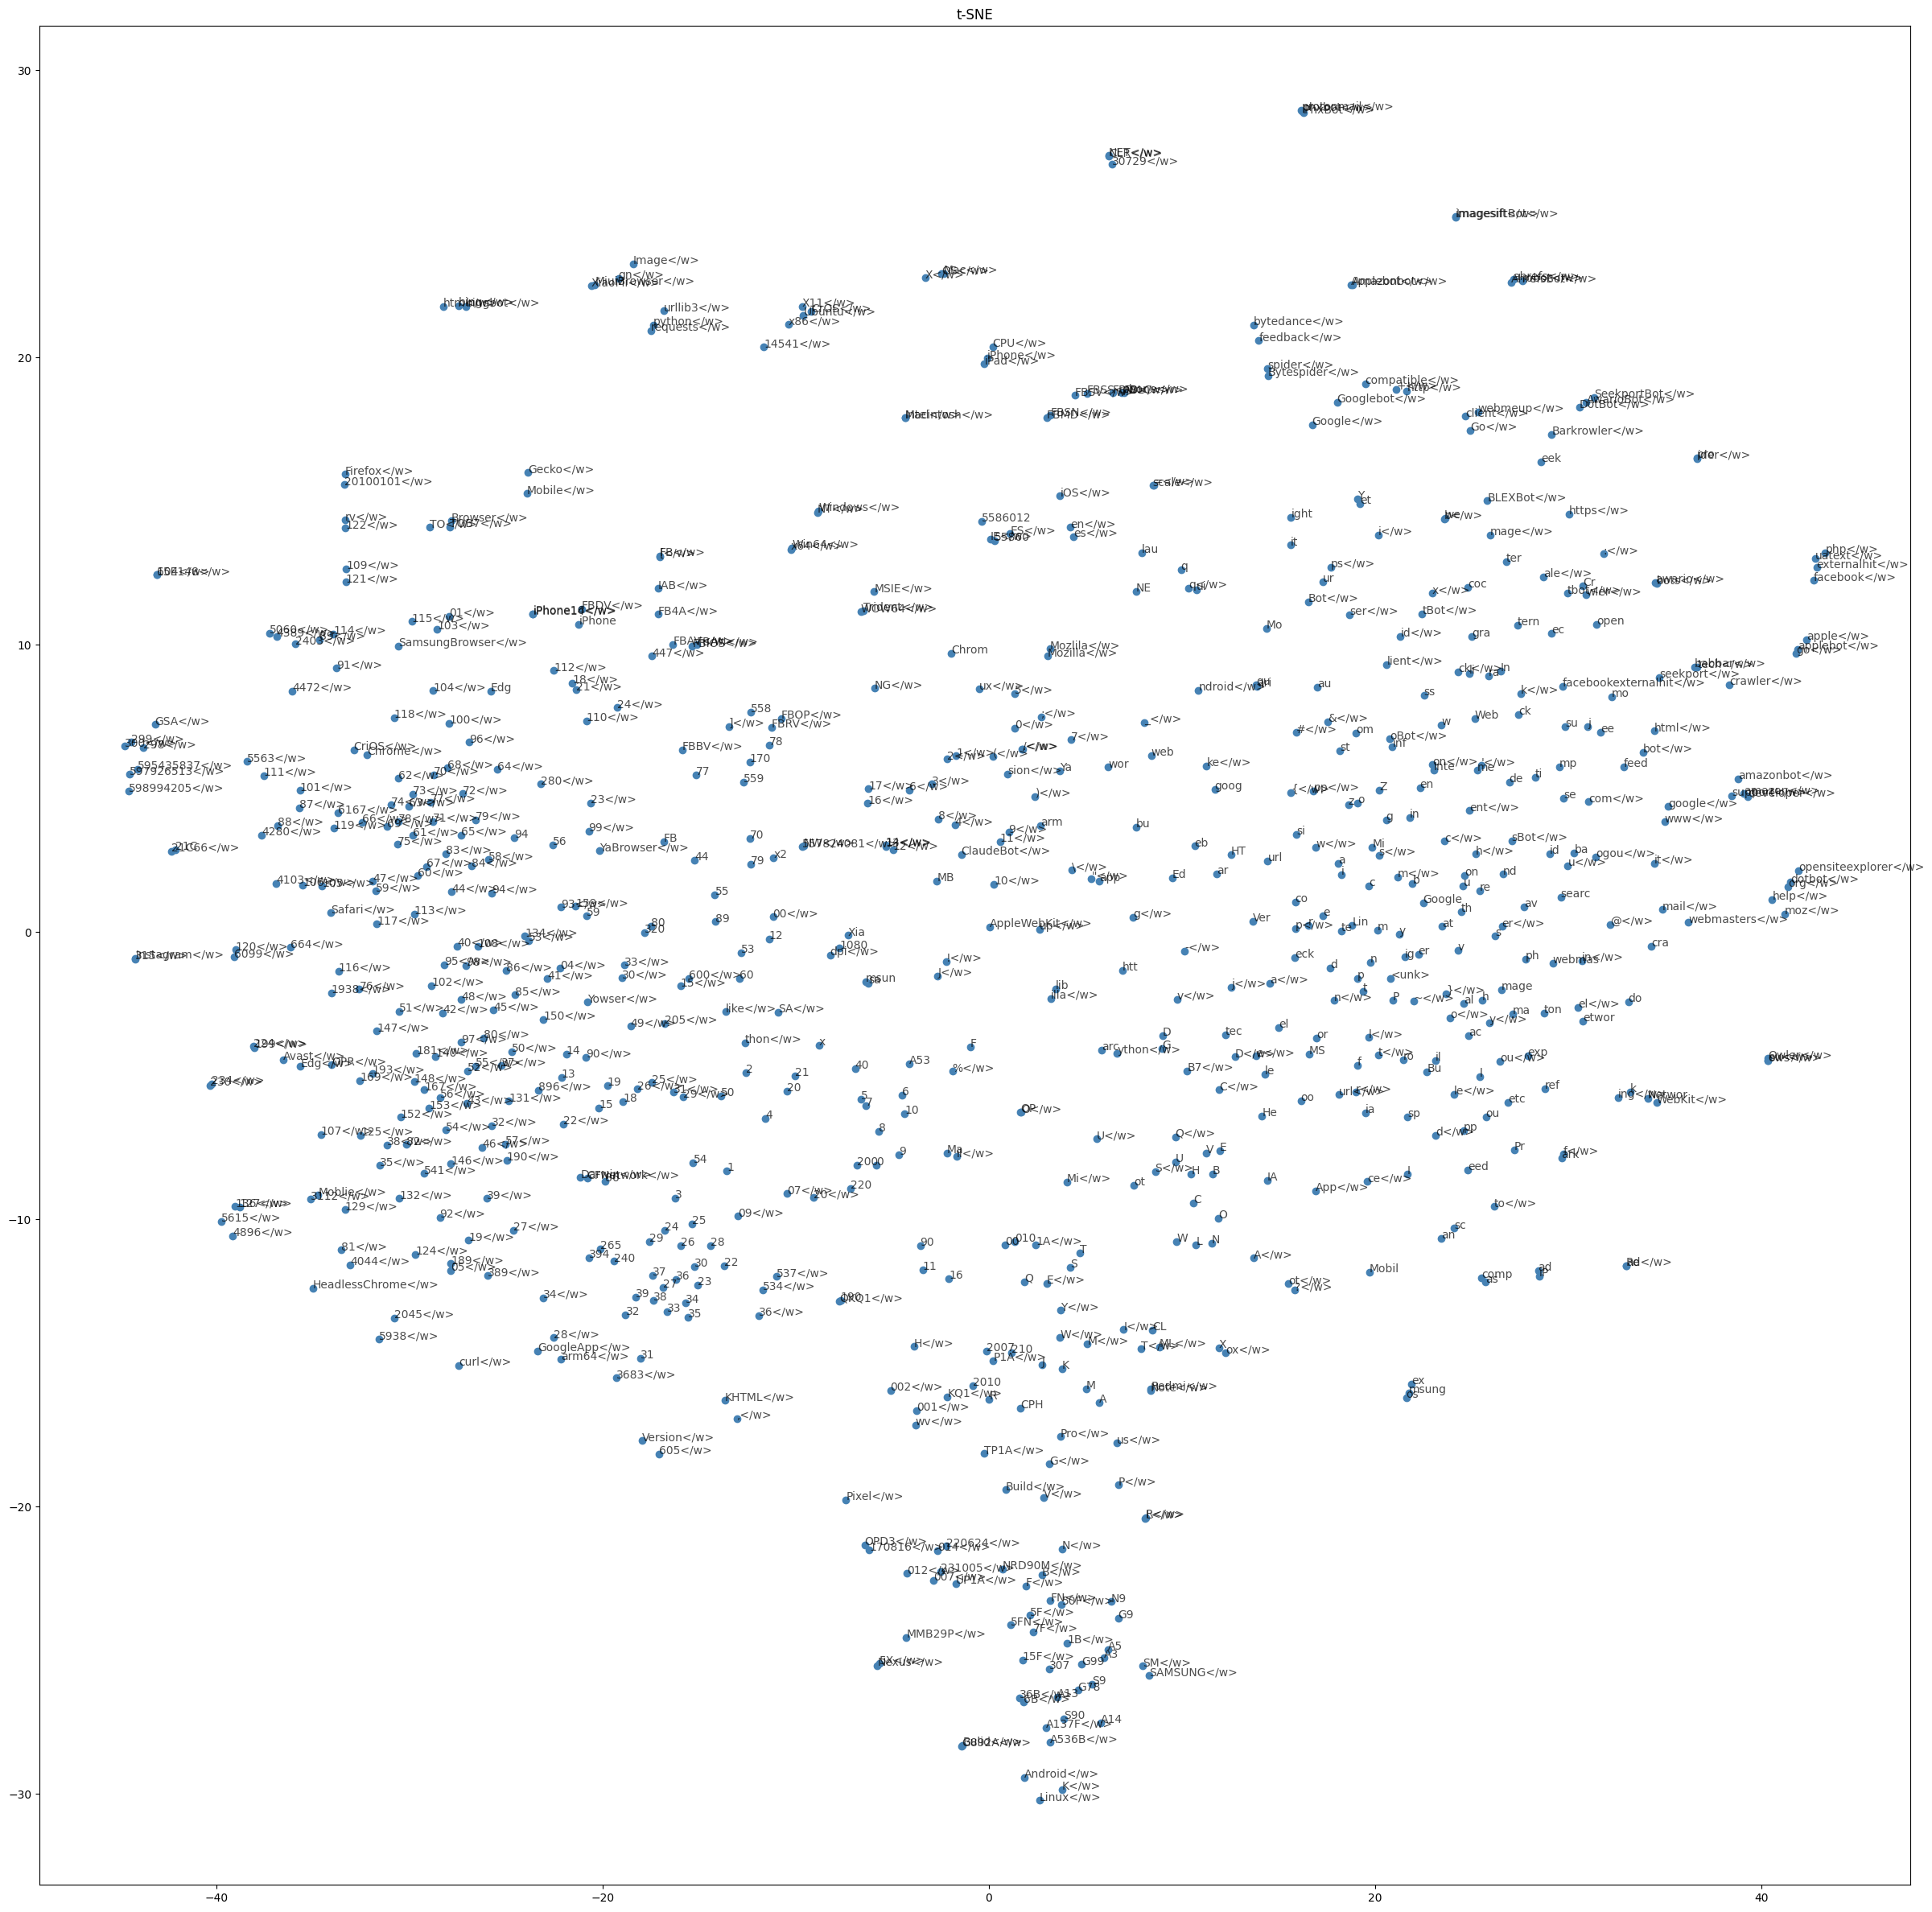

In [21]:
visualize_embeddings(
	embeddings,
	idx2word,
	n=len(vocab),
	method="tsne",
	figsize=(30, 30),
)

In [18]:
closest("Macintosh</w>", embeddings, idx2word)

[('Macintosh</w>', 0.0),
 ('Intel</w>', 4.588812351226807),
 ('Linux</w>', 6.643049240112305),
 ('Mozlila</w>', 6.976065158843994),
 ('7</w>', 7.133045196533203),
 ('10</w>', 7.191897392272949),
 ('Windows</w>', 7.30167818069458),
 ('AppleWebKit</w>', 7.304062843322754),
 ('Mozilla</w>', 7.311463832855225),
 ('OS</w>', 7.381263256072998)]

In [34]:
closest("Version</w>", embeddings, idx2word)

[('Version</w>', 0.0),
 ('31', 5.03241491317749),
 ('32', 5.102248191833496),
 ('69</w>', 5.105600357055664),
 ('app', 5.115305423736572),
 ('"</w>', 5.146663665771484),
 ('78</w>', 5.147114276885986),
 ('394', 5.154082775115967),
 ('119</w>', 5.171494007110596),
 ('74</w>', 5.1778564453125)]

## referer

In [2]:
referer = df["referer"]
referer.isna().sum(), dict(referer.value_counts(normalize=True))["-"]

(34, 0.18787794968993624)

In [3]:
referer[referer != "-"].str.len().describe()

count    874947.000000
mean         87.036143
std          30.713391
min          13.000000
25%          70.000000
50%          90.000000
75%         102.000000
max         923.000000
Name: referer, dtype: float64

In [4]:
referer = referer.sample(frac=1, random_state=42).reset_index(drop=True)
referer = referer.dropna()
referer = referer[referer != "-"]
referer.isna().sum(), dict(referer.value_counts(normalize=True)).get("-")

(0, None)

In [5]:
referer_corpus = referer.tolist()

In [13]:
# tokenizer = refine_tokenizer(
# 	model_dir=os.path.join(ROOT_DIR, "models"),
# 	model_prefix="charbpe-url",
# 	corpus=referer_corpus,
# 	extended_vocab_size=1200,
# 	min_frequency=10,
# 	save_prefix="charbpe-referer",
# 	save_dir=os.path.join(ROOT_DIR, "models"),
# )

Progress: 0%
Progress: 5%



Progress: 15%
Corpus tokenized. Extracting tokens...


100%|██████████| 874947/874947 [00:09<00:00, 95366.66it/s] 


Progress: 60%


100%|██████████| 874947/874947 [00:00<00:00, 1063350.79it/s]


Progress: 70%
Progress: 75%
Progress: 80%
Progress: 85%
Progress: 90%
Progress: 95%
Progress: 99%. Cross your fingers!
Progress: 100%


In [10]:
tokenized_referer_corpus = tokenize_corpus(referer_corpus, tokenizer)
trimmed_referer_corpus = trim_corpus(tokenized_referer_corpus, 5)

Corpus tokenized. Extracting tokens...


100%|██████████| 874947/874947 [00:07<00:00, 121784.27it/s]


In [22]:
tokens = [token for url in trimmed_referer_corpus for token in url]
vocab_t = set(tokenizer.get_vocab().keys())
vocab_c = set(tokens)
len(vocab_t), len(vocab_c)

(1407, 1058)

In [25]:
missing = vocab_t - vocab_c
not_missing = vocab_t & vocab_c
to_remove = []
for t1 in missing:
	found = False
	for t2 in not_missing:
		if t1 in t2:
			# print(t1, t2)
			found = True
	if not found:
		to_remove.append(t1)
to_remove[:5]

['cam', 'hoverIntent</w>', 's3</w>', 'webmanifest</w>', 'riber']

In [52]:
with open(os.path.join(ROOT_DIR, "models", "charbpe-referer-vocab.json"), "r") as f:
	vocab = json.load(f)
vocab_tokens = list(vocab.keys())
new_vocab = [t for t in vocab_tokens if t not in to_remove]
len(new_vocab), len(vocab_tokens)

(1181, 1407)

In [53]:
new_vocab = {t:i for i,t in enumerate(new_vocab)}
with open(os.path.join(ROOT_DIR, "models", "charbpe-referer-vocab.json"), "w") as f:
	json.dump(new_vocab, f)

In [54]:
with open(os.path.join(ROOT_DIR, "models", "charbpe-referer-merges.txt"), "r") as f:
	version = f.readline()
	old_merges = [line.split() for line in f.readlines()]
new_merges = []
for merge in old_merges:
	if merge[0] not in to_remove and merge[1] not in to_remove and "".join(merge) not in to_remove:
		new_merges.append(merge)
with open(os.path.join(ROOT_DIR, "models", "charbpe-referer-merges.txt"), "w") as f:
	f.write(version)
	f.write("\n".join([" ".join(merge) for merge in new_merges]))

In [6]:
tokenizer = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-referer")
len(tokenizer.get_vocab())

1181

In [8]:
url_tokenizer = load_tokenizer(os.path.join(ROOT_DIR, "models"), "charbpe-url")
len(url_tokenizer.get_vocab())

988

In [9]:
string = referer_corpus[2]
print(string)
print(tokenizer.encode(string).tokens)
print(url_tokenizer.encode(string).tokens)

https://www.sitgesanytime.com/fr/pl50/planifiez-votre-voyage/id85/urh-sitges-san-sebastian-playa.htm
['https</w>', ':</w>', '/</w>', '/</w>', 'www</w>', '.</w>', 'sitges', 'an', 'y', 'time</w>', '.</w>', 'com</w>', '/</w>', 'fr</w>', '/</w>', 'pl50</w>', '/</w>', 'planifiez</w>', '-</w>', 'votre</w>', '-</w>', 'voyage</w>', '/</w>', 'id8', '5</w>', '/</w>', 'ur', 'h</w>', '-</w>', 'sitges</w>', '-</w>', 'sa', 'n</w>', '-</w>', 'se', 'ba', 's', 'ti', 'an</w>', '-</w>', 'playa</w>', '.</w>', 'htm</w>']
['ht', 't', 'ps</w>', ':</w>', '/</w>', '/</w>', 'w', 'w', 'w</w>', '.</w>', 'sitges', 'an', 'y', 'ti', 'me</w>', '.</w>', 'co', 'm</w>', '/</w>', 'fr</w>', '/</w>', 'pl50</w>', '/</w>', 'planifiez</w>', '-</w>', 'votre</w>', '-</w>', 'voyage</w>', '/</w>', 'id8', '5</w>', '/</w>', 'ur', 'h</w>', '-</w>', 'sitges</w>', '-</w>', 'sa', 'n</w>', '-</w>', 'se', 'ba', 's', 'ti', 'an</w>', '-</w>', 'play', 'a</w>', '.</w>', 'htm</w>']


In [7]:
# clean_url = df[df["URL"].str.contains("HTTP").astype(bool)]["URL"].dropna()
# url_nohttp = clean_url.str.split().str[0]
# url_corpus = url_nohttp.to_list()
# combined_corpus = pd.Series(referer_corpus + url_corpus)
# combined_corpus = combined_corpus.sample(frac=1, random_state=42).reset_index(drop=True)
# combined_corpus = combined_corpus.to_list()
# len(combined_corpus), combined_corpus[:5]

(1951906,
 ['https://www.sitgesanytime.com/en/pl30/plan-your-trip/map-of-facilities/id35/colet-classic-penedes.htm',
  'https://www.sitgesanytime.com/ca/pag492/pl96/explora-platges-i-ports-2/id8/riera-xica.htm',
  'https://www.sitgesanytime.com/en/pl349/news/news/id555/la-capbussada-estrenara-el-calendari-d-activitats-del-2024.htm',
  '/plantilles/turisme/css/bg-video.css',
  '/comu/js/jquery-3.6.0.min.js'])

In [7]:
tokenized_referer_corpus = tokenize_corpus(referer_corpus, tokenizer)
trimmed_referer_corpus = trim_corpus(tokenized_referer_corpus, 5)

Corpus tokenized. Extracting tokens...


100%|██████████| 874947/874947 [00:05<00:00, 158491.53it/s]


In [8]:
word2idx, idx2word, vocab = create_lookup_tables(trimmed_referer_corpus)

In [9]:
subsampled_referer_corpus = subsample(trimmed_referer_corpus, word2idx, 1e-2)

100%|██████████| 874947/874947 [00:07<00:00, 110713.73it/s]


Subsampled 11670709 tokens from the corpus. 65.00% of the corpus remaining.


In [10]:
print(referer_corpus[0])
print(" ".join([idx2word[i] for i in subsampled_referer_corpus[0]]).replace("</w>", ""))

https://www.sitgesanytime.com/en/pl409/blog/id78/sitges-fishing-tourism.htm
https : / / www sitges an y time com / en pl409 blog id7 8 sitges fi sh ing tourism htm


In [11]:
len(vocab), len(tokenizer.get_vocab())

(1058, 1181)

In [13]:
# in_embeddings = load_embeddings(os.path.join(ROOT_DIR, "models", "embeddings-url.pt"))
# out_embeddings = load_embeddings(os.path.join(ROOT_DIR, "models", "embeddings-url-out.pt"))
# in_embeddings = nn.Embedding.from_pretrained(in_embeddings)
# out_embeddings = nn.Embedding.from_pretrained(out_embeddings)
# in_embeddings.weight.shape, out_embeddings.weight.shape

(torch.Size([923, 30]), torch.Size([923, 30]))

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 30
batch_size = 512
context_size = 5
n_neg_samples = 5

noise_dist = generate_noise_dist(subsampled_referer_corpus, len(vocab))
# model = PreTrainedSkipGram(len(vocab), embedding_dim, in_embeddings, out_embeddings, noise_dist).to(device)
model = SkipGram(len(vocab), embedding_dim, noise_dist=noise_dist).to(device)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
train_skipgram(
	model=model,
	criterion=criterion,
	optimizer=optimizer,
	subsampled_corpus=subsampled_referer_corpus,
	device=device,
	batch_size=batch_size,
	context_size=context_size,
	n_epochs=1,
	n_neg_samples=n_neg_samples,
	print_every=(50, 1000),
	idx2word=idx2word
)

Epoch  1/ 1 | Batch 42301/42338 | Loss: 1.7673
https</w> | www</w>, :</w>, sitges, com</w>, y
/</w> | time</w>, com</w>, www</w>, sitges, pl30</w>
a</w> | per</w>, r</w>, peu</w>, vi, vid
an | www</w>, https</w>, :</w>, sitges, y
teu</w> | viatge</w>, planifica</w>, donde</w>, el</w>, mapa</w>
id4 | id2, id3, id1, 45</w>, id5
t | ja</w>, blic, ke, nac, O</w>
r | ungs, ke, I</w>, er</w>, ki
ihre</w> | reise</w>, planen</w>, sie</w>, uber, auf</w>
t</w> | ge</w>, sele, te</w>, mu, re



In [14]:
path = os.path.join(ROOT_DIR, 'models/embeddings-referer.pt')
save_embeddings(model, path)
embeddings = load_embeddings(path)

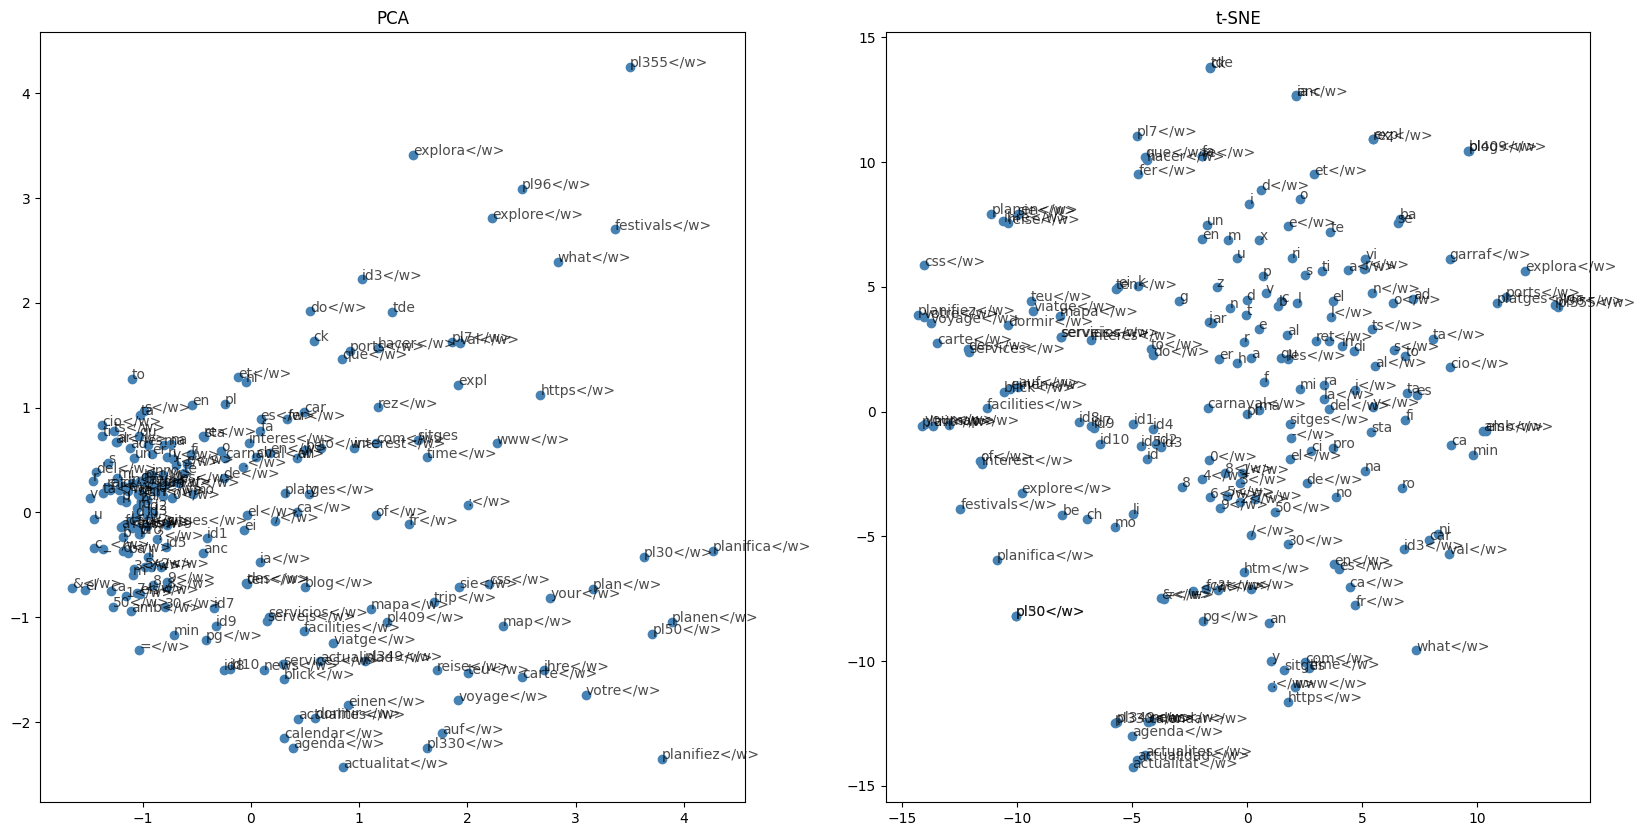

In [15]:
visualize_embeddings(
	embeddings=embeddings,
	idx2word=idx2word,
	n=200,
	method="both",
	figsize=(20, 10)
)

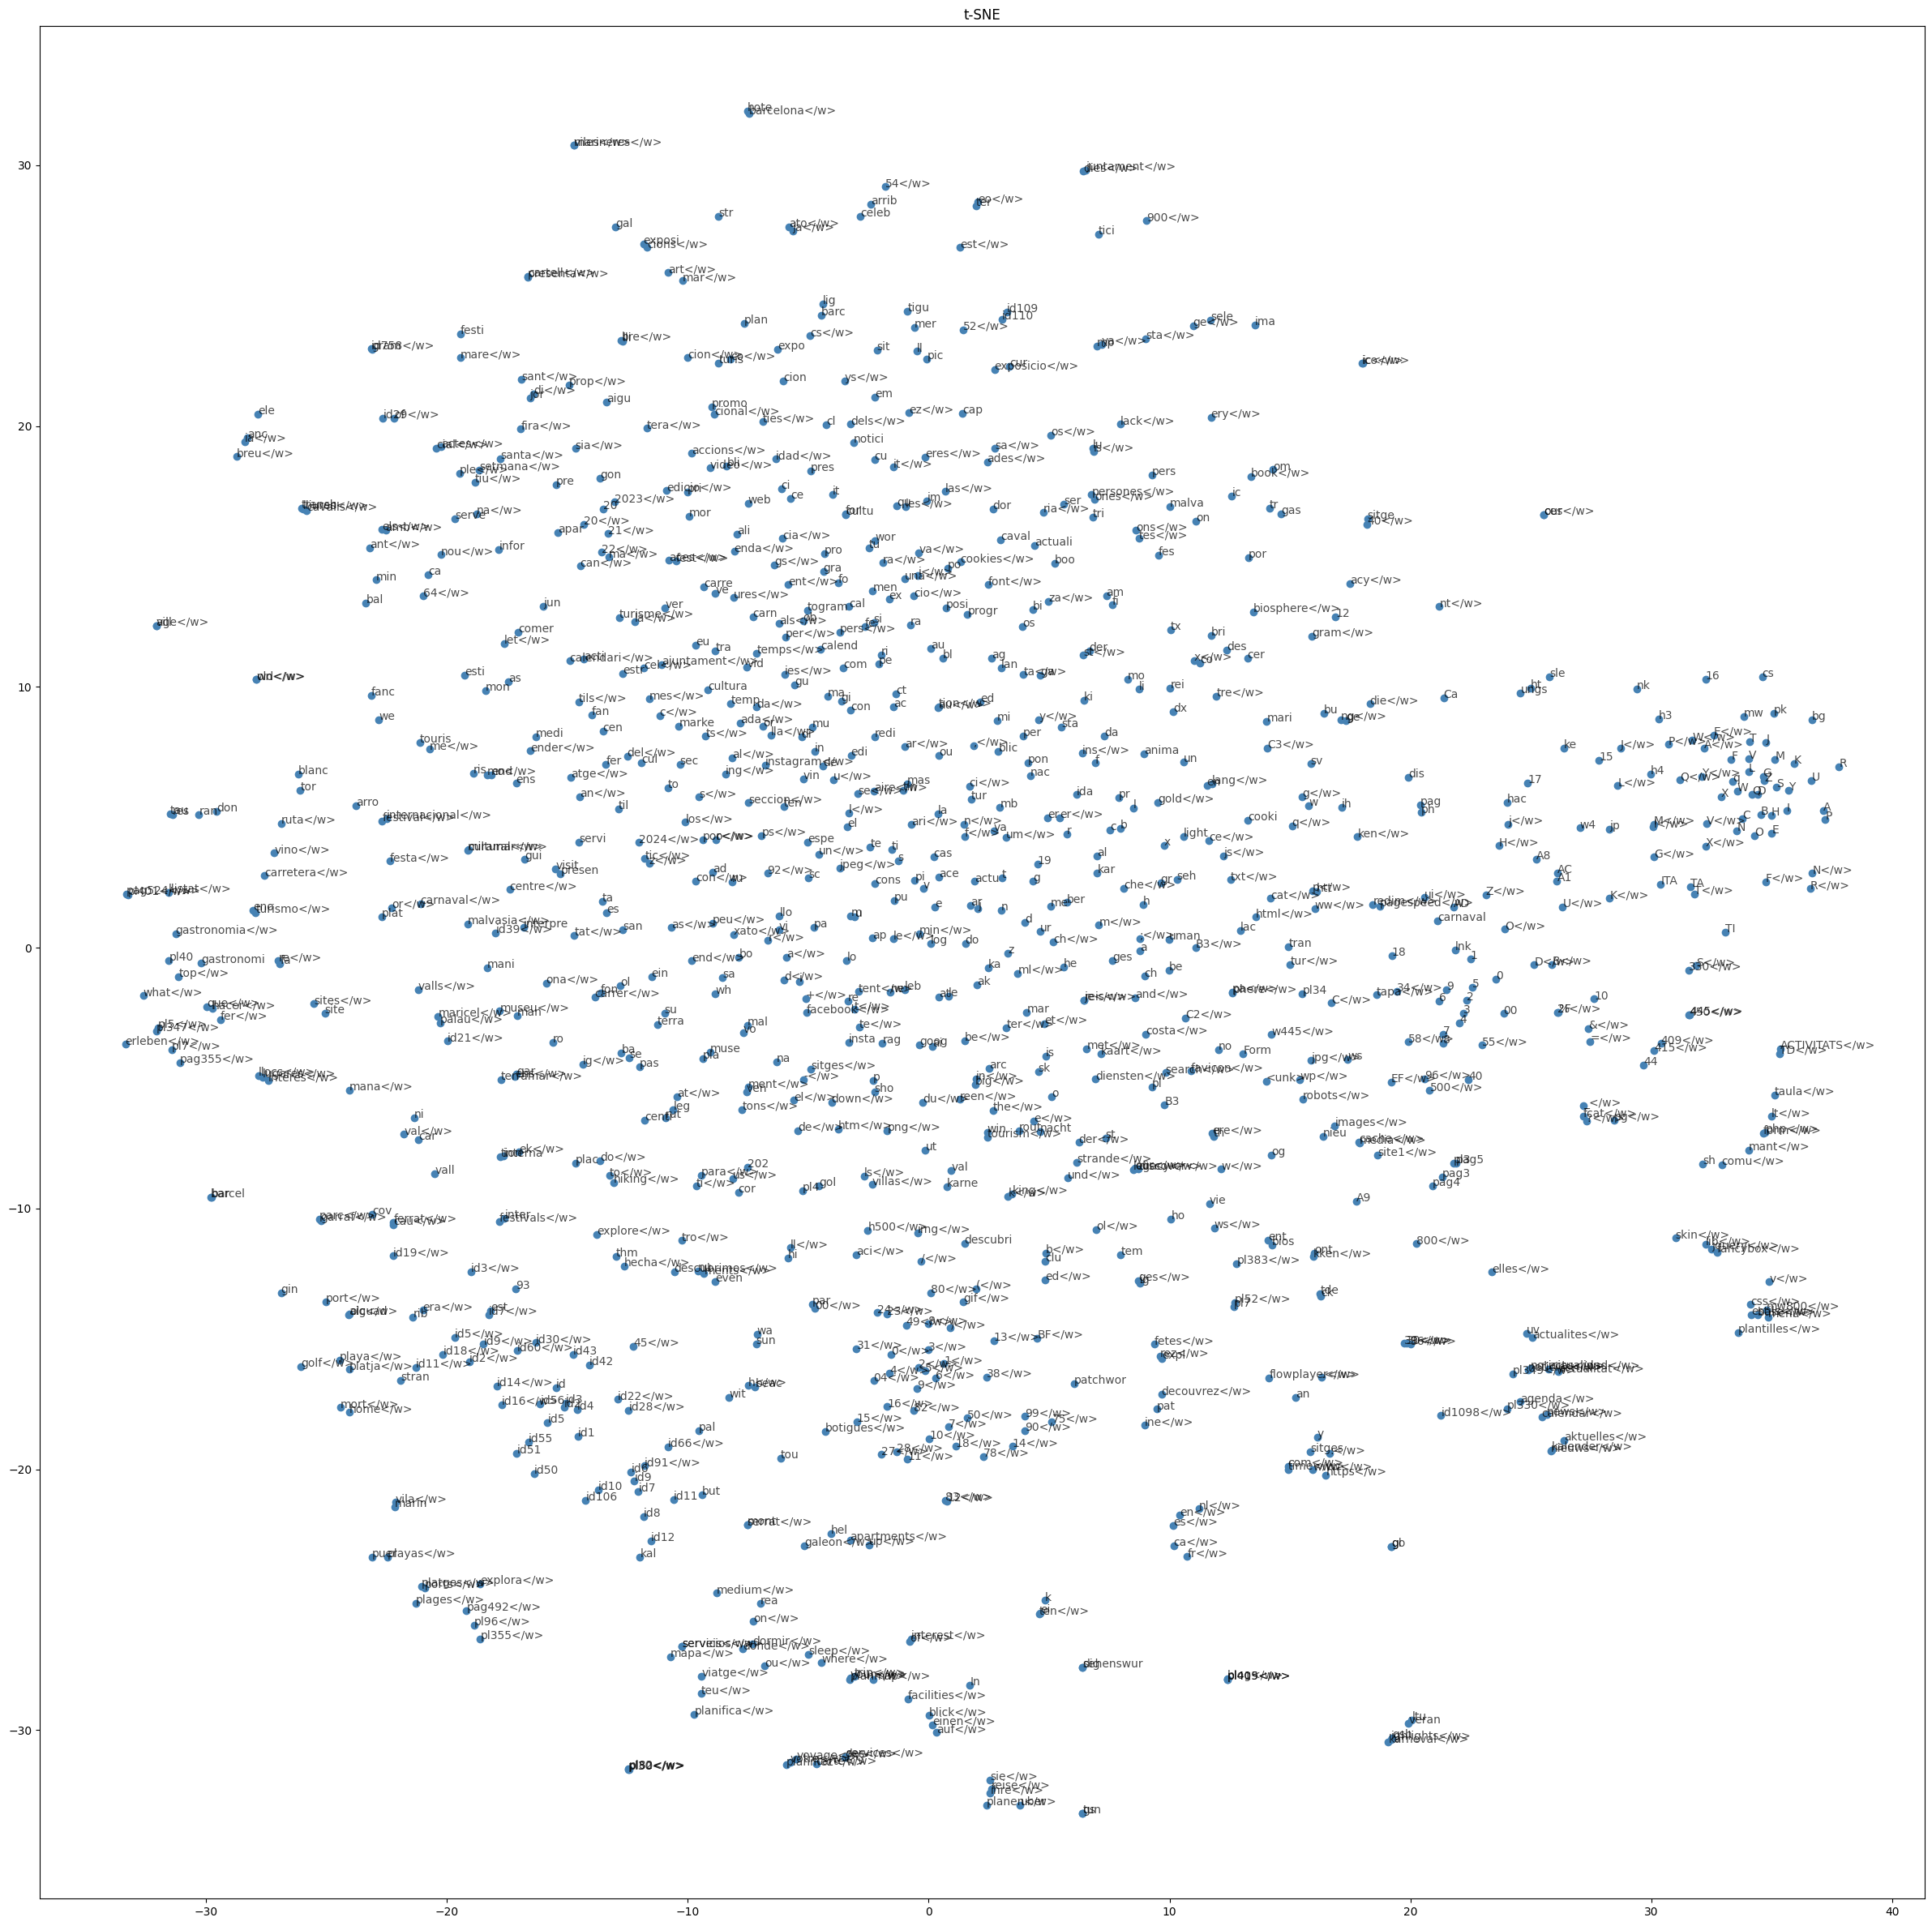

In [16]:
visualize_embeddings(
	embeddings=embeddings,
	idx2word=idx2word,
	n=embeddings.shape[0],
	method="tsne",
	figsize=(30, 30)
)

In [17]:
closest("fr</w>", embeddings, idx2word)

[('fr</w>', 0.0),
 ('ca</w>', 4.235876083374023),
 ('nl</w>', 4.455286979675293),
 ('actualites</w>', 4.80833625793457),
 ('des</w>', 4.819542407989502),
 ('en</w>', 4.885665416717529),
 ('es</w>', 4.9143967628479),
 ('A9', 4.946873188018799),
 ('/</w>', 4.971479892730713),
 ('13</w>', 4.973888397216797)]

In [18]:
closest("id11", embeddings, idx2word)

[('id11', 0.0),
 ('id7', 2.8502492904663086),
 ('id1', 3.1667630672454834),
 ('id9', 3.176776885986328),
 ('id8', 3.216402053833008),
 ('but', 3.2552876472473145),
 ('hi', 3.5048770904541016),
 ('id56', 3.755028009414673),
 ('id91</w>', 3.795489549636841),
 ('id6', 3.796321153640747)]

In [19]:
closest("https</w>", embeddings, idx2word)

[('https</w>', 0.0),
 ('www</w>', 3.5125415325164795),
 (':</w>', 3.8601365089416504),
 ('sitges', 4.019087791442871),
 ('com</w>', 4.194535732269287),
 ('y', 4.374625205993652),
 ('time</w>', 4.3996453285217285),
 ('an', 4.64333963394165),
 ('robots</w>', 4.7766923904418945),
 ('lib</w>', 4.9853739738464355)]

In [20]:
closest("id22</w>", embeddings, idx2word)

[('id22</w>', 0.0),
 ('id6', 2.966459035873413),
 ('id19</w>', 3.0861806869506836),
 ('id2', 3.119858980178833),
 ('par', 3.132133960723877),
 ('id28</w>', 3.1485347747802734),
 ('id42', 3.2141761779785156),
 ('id30</w>', 3.2173707485198975),
 ('id4', 3.244917869567871),
 ('id91</w>', 3.352147102355957)]

In [23]:
closest("82</w>", embeddings, idx2word)

[('82</w>', 0.0),
 ('instagram</w>', 3.113128662109375),
 ('serveis</w>', 3.159517526626587),
 ('aci</w>', 3.22634220123291),
 ('man', 3.2372488975524902),
 ('carnaval</w>', 3.255258083343506),
 ('vin', 3.29833984375),
 ('me</w>', 3.3008482456207275),
 ('ele', 3.3267576694488525),
 ('mo', 3.3361775875091553)]